# Project: Web Data Pipeline

In [1]:
import requests
import json
from pandas.io.json import json_normalize;
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cases_endpt = 'https://api.gdc.cancer.gov/cases'

## Part 1: Data retrival, unpacking, and organization

In [3]:
def get_cases():
    
    count = 0
    max_count = 33605
    
    list_of_dfs = []
    fields = [
    "submitter_id",
    "case_id",
    "primary_site",
    "disease_type",
    "diagnoses.vital_status",
    "demographic.gender",
    "demographic.ethnicity",
    "demographic.race",
    "demographic.state",
    "demographic.year_of_birth",
    "demographic.year_of_death",
    "exposures.alcohol_history",
    "exposures.alcohol_intensity",
    "exposures.bmi",
    "exposures.height",
    "exposures.weight",
    "exposures.years_smoked",
    "exposures.cigarettes_per_day",
    "created_datetime",
    "project.project_id"
    ]
    
    fields = ','.join(fields)
    
    while count < max_count:
    
        params = {
        "fields": fields,
        "format": "JSON",
        "from":count, "size":1000
        }
        
        count += 1000
        
        response = requests.get(cases_endpt, params = params)
        print(response)

        data = response.json()
        df = pd.DataFrame(data)
        
        df = pd.DataFrame(df.data.hits)
# #         print statements to monitor size, shape, and dimension of dataframes
#         print(count/1000, ' ', df.size, df.shape, df.ndim)
#         print(df.columns)
        
        if 'exposures' not in df.columns:
            df.insert(loc = 4, column = 'exposures', value = 0)
# #         print statements to check size, shape, and dimensions of dataframes after eventual insertion of missing column
#         print('after inserting: ', count/1000, ' ', df.size, df.shape, df.ndim)
#         print(df.columns)
#         print()

        list_of_dfs.append(df)
    
    return list_of_dfs

In [4]:
full_list = get_cases()

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [5]:
# merge dataframes from list_of_dfs
def merge_dfs(x):
    
    merged_df = pd.concat(x, axis = 0, ignore_index = True)
    return merged_df

In [6]:
raw_df = merge_dfs(full_list)

In [7]:
# unpack dictionaries
def unpack_dictionaries(dict1, dict2, dict3):
    # unpacking demographics dictionary
    df_demographics = dict1.apply(pd.Series)
    # assigning new df for exposures, first column (index = 0) contains dictionary
    df_exposures_dict = dict2.apply(pd.Series)
    # unpacking exposures dictionary
    df_exposures = df_exposures_dict[0].apply(pd.Series)
    # unpacking project dictionary
    df_project = dict3.apply(pd.Series)
    
    combined_df = pd.merge(raw_df, df_demographics, left_index=True, right_index=True)
    combined_df = pd.merge(combined_df, df_exposures, left_index=True, right_index=True)
    combined_df = pd.merge(combined_df, df_project, left_index=True, right_index=True)

    return combined_df

In [8]:
unpacked_df = unpack_dictionaries(raw_df.demographic, raw_df.exposures, raw_df.project)

In [9]:
def drop_reorder_columns(df):
    # drop columns previously containing the dictionaries
    df.drop(['demographic', 'exposures', '0_x', '0_y'], axis=1, inplace=True)
    # reorder columns
    reordered_df = df[['case_id','disease_type','primary_site','year_of_birth','year_of_death','gender','race','ethnicity','state','height','weight','bmi','alcohol_history','alcohol_intensity','years_smoked','cigarettes_per_day','created_datetime','project_id','id','submitter_id']]
    return reordered_df

In [10]:
reordered_df = drop_reorder_columns(unpacked_df)

In [11]:
def save_csv(df):
    df.to_csv('cancer_ordered_raw.csv')

In [12]:
save_csv(reordered_df)

## Part 2: Data cleaning/subsetting, analysis, and visualization

In [13]:
def read_data(file):
    df_cancer = pd.read_csv(file, low_memory = False)
    return df_cancer

In [14]:
df_cancer = read_data('cancer_ordered_raw.csv')

In [15]:
def graph_cases_alc_history(df):
    objects = ('Alcohol history: Yes', 'Alcohol history:No')
    y_pos = np.arange(len(objects))
    ax_x = [len(df.loc[df['alcohol_history'] == 'Yes']),len(df.loc[df['alcohol_history'] == 'No'])]

    plt.bar(y_pos, ax_x, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Alcohol history')
    plt.ylabel('Entries')
    plt.title('Numbers of entries with alcohol history recorded')

    plt.show()

### Numbers of cases with alcohol history = 'yes' and alcohol history = 'no'

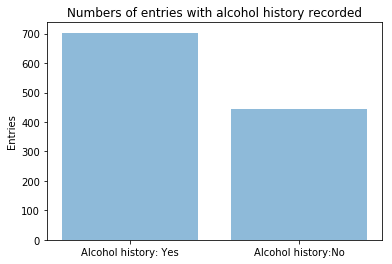

In [16]:
graph_cases_alc_history(df_cancer)

In [17]:
def numbers_cases_alc_history(df):
    print("Entries with alcohol history recorded: " +str(len(df.loc[df['alcohol_history'] == 'Yes']) + len(df.loc[df['alcohol_history'] == 'No'])) + "\n")
    print("Entries with alcohol history = 'yes': " + str(len(df.loc[df['alcohol_history'] == 'Yes'])))
    print("Entries with alcohol history = 'no': " + str(len(df.loc[df['alcohol_history'] == 'No'])))

In [18]:
numbers_cases_alc_history(df_cancer)

Entries with alcohol history recorded: 1148

Entries with alcohol history = 'yes': 703
Entries with alcohol history = 'no': 445


In [19]:
def subset_df_alc_hist(df):
    df_cancer_alc_hist = df.loc[df['alcohol_history'] == 'Yes'].append(df.loc[df['alcohol_history'] == 'No'])
    return df_cancer_alc_hist

In [20]:
subset_df_alc_hist(df_cancer)

,Unnamed: 0,case_id,disease_type,primary_site,year_of_birth,year_of_death,gender,race,ethnicity,state,...,weight,bmi,alcohol_history,alcohol_intensity,years_smoked,cigarettes_per_day,created_datetime,project_id,id,submitter_id
12,12,b1114673-0f13-4265-98d8-21c5714d91a4,Adenomas and Adenocarcinomas,Kidney,1944.0,NaN,male,white,not hispanic or latino,released,...,122.000000,38.94,Yes,Occasional Drinker,40.0,20.000000,2017-09-04T10:20:52.321423-05:00,CPTAC-3,b1114673-0f13-4265-98d8-21c5714d91a4,C3L-00360
15,15,8919013d-01db-4469-b0a6-553dd25fda6d,Adenomas and Adenocarcinomas,Bronchus and lung,1943.0,2017.0,male,not reported,not reported,released,...,74.000000,23.89,Yes,Occasional Drinker,41.0,20.000000,2018-06-12T09:10:41.319940-05:00,CPTAC-3,8919013d-01db-4469-b0a6-553dd25fda6d,C3N-02586
18,18,decd7489-bb2e-44a2-b934-2f962c5a7f41,Adenomas and Adenocarcinomas,Bronchus and lung,1938.0,NaN,female,white,not hispanic or latino,released,...,63.956524,24.20,Yes,Occasional Drinker,18.0,10.000000,2017-12-20T12:18:42.407753-06:00,CPTAC-3,decd7489-bb2e-44a2-b934-2f962c5a7f41,C3L-01682
24,24,0a94d173-c451-4367-9e54-968bd0e0dc0b,Adenomas and Adenocarcinomas,Bronchus and lung,1961.0,NaN,male,not reported,not reported,released,...,62.000000,24.22,Yes,Occasional Drinker,22.0,7.000000,2017-09-04T10:20:52.321423-05:00,CPTAC-3,0a94d173-c451-4367-9e54-968bd0e0dc0b,C3N-00560
29,29,8be8aafe-ccd7-437f-aa68-09c4bc248d1d,Adenomas and Adenocarcinomas,Kidney,1936.0,NaN,male,not reported,not reported,released,...,90.000000,30.78,Yes,Occasional Drinker,NaN,NaN,2017-09-04T10:20:52.321423-05:00,CPTAC-3,8be8aafe-ccd7-437f-aa68-09c4bc248d1d,C3N-01522
31,31,1570eaf1-9b92-4506-9df0-9ae9a704a731,Adenomas and Adenocarcinomas,Kidney,1975.0,NaN,male,asian,not hispanic or latino,released,...,77.110703,22.43,Yes,Occasional Drinker,NaN,NaN,2017-09-04T10:20:52.321423-05:00,CPTAC-3,1570eaf1-9b92-4506-9df0-9ae9a704a731,C3N-00953
32,32,41078a19-092c-4930-a3f4-eca47256622e,Adenomas and Adenocarcinomas,Bronchus and lung,1952.0,NaN,male,white,hispanic or latino,released,...,73.630000,25.42,Yes,Occasional Drinker,NaN,NaN,2017-12-20T12:18:42.407753-06:00,CPTAC-3,41078a19-092c-4930-a3f4-eca47256622e,C3L-02508
34,34,e51dd5ca-c12d-4608-9e6e-73b658b106d6,Adenomas and Adenocarcinomas,Bronchus and lung,1972.0,NaN,male,not reported,not reported,released,...,56.000000,20.57,Yes,Occasional Drinker,21.0,5.000000,2017-12-20T12:18:42.407753-06:00,CPTAC-3,e51dd5ca-c12d-4608-9e6e-73b658b106d6,C3N-02155
37,37,2f344e9f-478a-40a2-99c9-3435fd0b9bbe,Adenomas and Adenocarcinomas,Kidney,1931.0,NaN,male,not reported,not reported,released,...,84.000000,28.00,Yes,Occasional Drinker,2.0,10.000000,2017-08-09T11:56:04.005681-05:00,CPTAC-3,2f344e9f-478a-40a2-99c9-3435fd0b9bbe,C3N-00310
40,40,a587c48a-28fb-43b2-8b6c-90218f864f26,Adenomas and Adenocarcinomas,Kidney,1982.0,NaN,female,white,hispanic or latino,released,...,90.264882,36.39,Yes,Occasional Drinker,18.0,1.000000,2017-09-04T10:20:52.321423-05:00,CPTAC-3,a587c48a-28fb-43b2-8b6c-90218f864f26,C3L-00183


In [21]:
def plot_top15_primary_sites(df):
    plt=df['primary_site'].value_counts()[:15].plot.pie(figsize= (14, 8))
    plt.set_ylabel('');

### Top 15 primary sites recorded in the dataset

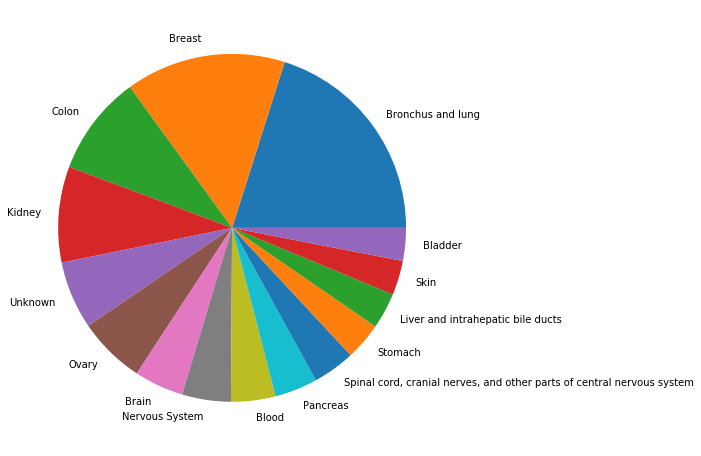

In [22]:
plot_top15_primary_sites(df_cancer)

### Top 15 primary sites recorded in the subset reporting alcohol history specifically as 'yes' or 'no'

In [23]:
def plot_top15_primary_sites_alc_hist(df):
    plot_top15_primary_sites(df)

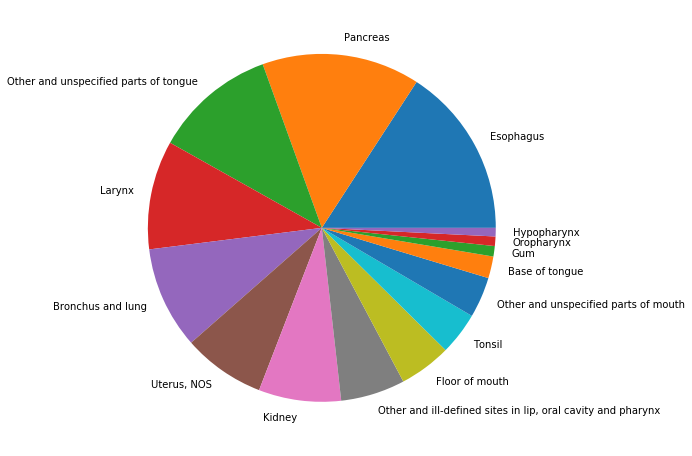

In [24]:
plot_top15_primary_sites_alc_hist(subset_df_alc_hist(df_cancer))

In [25]:
def plot_counts_prim_site(df):
    plot = df.groupby(['primary_site','alcohol_history']).size().unstack().plot(kind='bar',stacked=False, figsize=(16, 6))
    plot.set_xlabel("Primary site", fontsize = 20)
    plot.set_ylabel("Count", fontsize = 20)
    plot.tick_params(axis='x', which='major', labelsize='large', labelcolor='black', rotation=90)

### Case counts by primary site (not normalized to number of patients within each group)

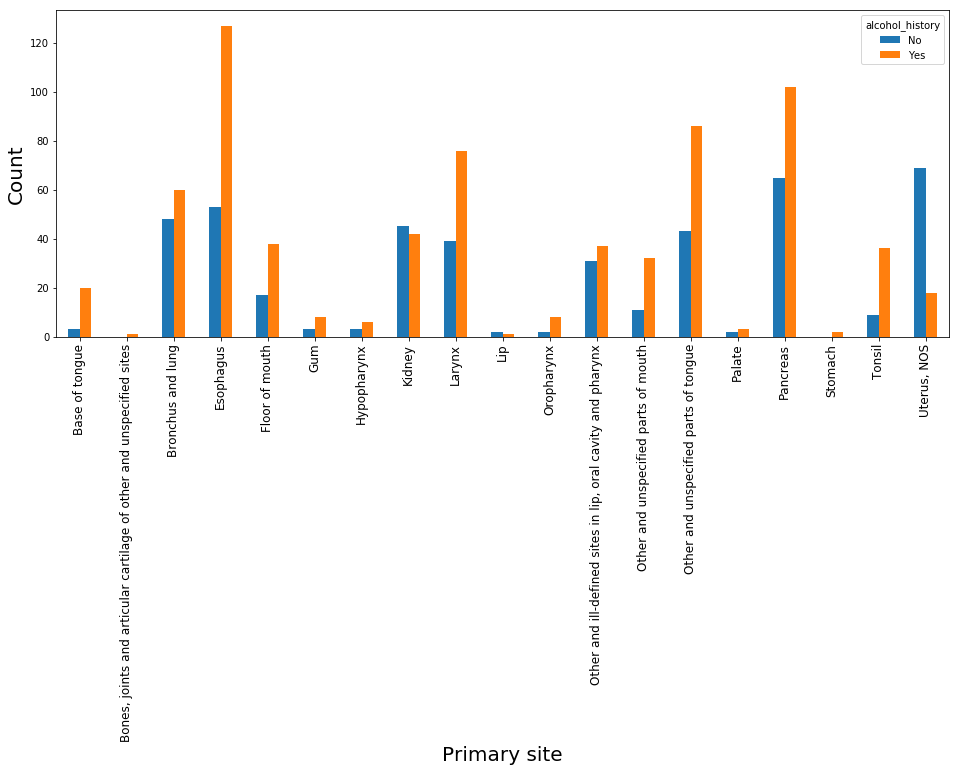

In [26]:
plot_counts_prim_site(subset_df_alc_hist(df_cancer))

In [27]:
def normalize_alc_hist(df):
    count_site_yes = df.loc[df['alcohol_history'] == 'Yes'].groupby('primary_site').count()
    count_site_no = df.loc[df['alcohol_history'] == 'No'].groupby('primary_site').count()
    norm_count_alc_yes = (count_site_yes["Unnamed: 0"]/len(df.loc[df['alcohol_history'] == 'Yes'])*100)
    norm_count_alc_no = (count_site_no["Unnamed: 0"]/len(df.loc[df['alcohol_history'] == 'No'])*100)
    
    df_site_alc_norm = pd.concat([norm_count_alc_no, norm_count_alc_yes], axis=1, sort=True)
    df_site_alc_norm = df_site_alc_norm.set_axis(['Alc_No', 'Alc_Yes'], axis=1, inplace=False)
    df_site_alc_norm = df_site_alc_norm.rename_axis(('Primary Site'))
    df_site_alc_norm = df_site_alc_norm.reset_index()
    return df_site_alc_norm

### Table listing percentages of patients with alcohol history = 'yes' and alcohol history = 'no' normalized to number of patients within each group

In [28]:
normalize_alc_hist(df_cancer)

,Primary Site,Alc_No,Alc_Yes
0,Base of tongue,0.674157,2.844950
1,"Bones, joints and articular cartilage of other...",NaN,0.142248
2,Bronchus and lung,10.786517,8.534851
3,Esophagus,11.910112,18.065434
4,Floor of mouth,3.820225,5.405405
5,Gum,0.674157,1.137980
6,Hypopharynx,0.674157,0.853485
7,Kidney,10.112360,5.974395
8,Larynx,8.764045,10.810811
9,Lip,0.449438,0.142248


In [29]:
def plot_counts_prim_site_normalized(df):
    plot = df.plot.bar(x='Primary Site', figsize = (16, 6))
    plot.set_xlabel("Primary site", fontsize = 20)
    plot.set_ylabel("Percent", fontsize = 20)

### Percentages of case counts by primary site (normalized to number of patients within each group)

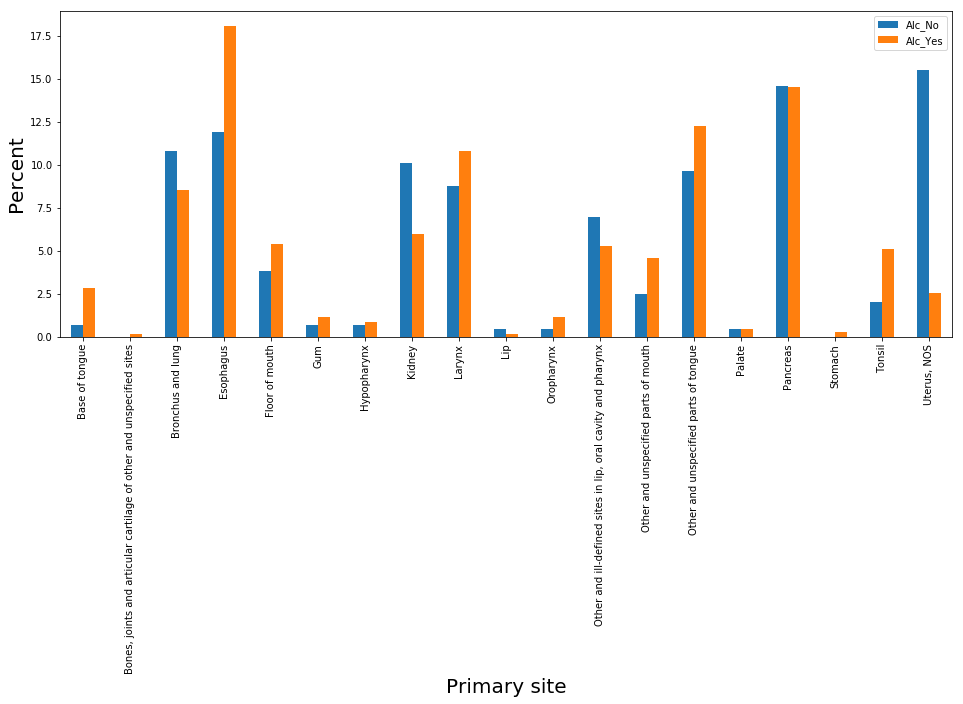

In [30]:
plot_counts_prim_site_normalized(normalize_alc_hist(df_cancer))